# Project 4 Data science OC 
## Forecasting the total electric consumption and the CO2 emissions of the Seatle buldings

> Background

Seatle intend to be a neutral city in 2050 with regard the CO2 emissions.<br>
Based on 2015 ans 2016 datas for this very city, the mission consist in forecasting the CO2 emissions and the total energy consumption of the city of Seatle.

Espcially a focus has to be done on non residential buildings.

The forecast has to be based on the following:
* Size and usage of the buildings
* Maintenance and repair of those buildings
* Construction date

The energy star score relevance has to be evaluated in the CO2 emissions.

> Expectations

We'll want to predict the Site energy use and the GHG emissions.

We'll performe two analysis and so two different datasets with one target each.

In each one we'll drop the other target.


# Table of contents

[Modules import](#module)

[Pipeline transformation](#pipeline_tr)

[Comparing models](#compare_mod)
*   [Comparing models on EUI](#compare_mod_eui)
*   [Comparing models on GHG](#compare_mod_ghg)

[Analysing Energy star score](#energy_star)

# Module import

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

from sklearn.model_selection import train_test_split

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import datetime

import sklearn
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import *
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import  make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
#from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
#from sklearn.preprocessing import MinMaxScaler
#from sklearn.preprocessing import MaxAbsScaler
from sklearn import kernel_ridge
import xgboost as xgb
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from scipy.stats import kendalltau
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings("ignore")

/Users/jean-baptisteherold/opt/anaconda3/envs/Working/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# Versions
print('Versions used:')
print('Python                : ' + sys.version)
print('NumPy                 : ' + np.version.full_version)
print('Pandas                : ' + pd.__version__)
print('Matplotlib            : ' + matplotlib.__version__)
print('Seaborn               : ' + sns.__version__)
print('Sklearn               : ' + sklearn.__version__)
print('XGBoost               : ' + xgb.__version__)
now = datetime.datetime.now().isoformat()
print('Launched on             : ' + now)

Versions used:
Python                : 3.9.7 (default, Sep 16 2021, 08:50:36) 
[Clang 10.0.0 ]
NumPy                 : 1.21.2
Pandas                : 1.4.1
Matplotlib            : 3.5.1
Seaborn               : 0.11.2
Sklearn               : 1.0.2
XGBoost               : 1.5.0
Launched on             : 2022-10-01T19:05:08.398007


In [3]:
#import csv file prepared in the other notebook
df_prepared = pd.read_csv('prepared_dataset.csv')

In [4]:
df_prepared.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 957 entries, 0 to 956
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   BuildingType            957 non-null    object 
 1   PrimaryPropertyType     957 non-null    object 
 2   NumberofFloors          957 non-null    float64
 3   PropertyGFABuilding(s)  957 non-null    int64  
 4   ENERGYSTARScore         665 non-null    float64
 5   SiteEnergyUse(kBtu)     957 non-null    float64
 6   TotalGHGEmissions       957 non-null    float64
 7   BuildingAge             957 non-null    int64  
 8   Location                957 non-null    object 
 9   SteamUse %              957 non-null    float64
 10  Electricity %           957 non-null    float64
 11  NaturalGas %            957 non-null    float64
 12  total other type %      957 non-null    float64
 13  location_type           957 non-null    object 
dtypes: float64(8), int64(2), object(4)
memory 

At this stage we have a dataset cleaned.

This dataset is constituted of numerical and categorical variables.




# Columns Tranformer Pipelines <a class="anchor" id="pipeline_tr"></a>



We have several categorical variables to one-hot encode:
*   BuildingType
*   PrimaryPropertyType
*   Location 
*   location_type

We have some numerical variables to scale. we'll use RobustScaler as it preserves outliered distributions
*   NumberofFloors
*   PropertyGFABuilding(s)
*   BuildingAge
*   SteamUse %
*   Electricity %
*   NaturalGas %
*   total other type %

The targert will be loged as their distributions contains a very wide range of values

*   SiteEnergyUse(kBtu)
*   TotalGHGEmissions

In [5]:
#dropping energystarscore as it won't be used in the models first
df_model = df_prepared.drop(columns=['ENERGYSTARScore'])
#creating two different datasets. One for EUI and one for GHG.
df_ghg = df_model.drop(columns=['SiteEnergyUse(kBtu)'])
df_eui = df_model.drop(columns=['TotalGHGEmissions'])

In [6]:
#log targets
logtransformer = FunctionTransformer(np.log, inverse_func = np.exp, check_inverse = True)
df_eui['SiteEnergyUse(kBtu)'] = logtransformer.transform(df_eui['SiteEnergyUse(kBtu)'])
df_ghg['TotalGHGEmissions'] = logtransformer.transform(df_ghg['TotalGHGEmissions'])

In [7]:
#creating X and y variables
X_ghg = df_ghg.drop(columns= ['TotalGHGEmissions'])
y_ghg = df_ghg['TotalGHGEmissions']

X_eui = df_eui.drop(columns=['SiteEnergyUse(kBtu)'])
y_eui = df_eui['SiteEnergyUse(kBtu)']

In [8]:
X_train_ghg, X_test_ghg, y_train_ghg, y_test_ghg = train_test_split(X_ghg, y_ghg, test_size=0.25, random_state=10, shuffle=True)
X_train_eui, X_test_eui, y_train_eui, y_test_eui = train_test_split(X_eui, y_eui, test_size=0.25, random_state=10, shuffle=True)

#### Pipeline creation

In [9]:
numeric_features = ["NumberofFloors", "PropertyGFABuilding(s)", "BuildingAge", "SteamUse %", "Electricity %", "NaturalGas %", "total other type %"]
numeric_transformer = RobustScaler()

categorical_features = ["BuildingType", "PrimaryPropertyType", "Location", "location_type"]
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[("num", numeric_transformer, numeric_features), ("cat", categorical_transformer, categorical_features)])


# Comparing multiple models<a class="anchor" id="compare_mod"></a>

We first want to test many models on the whole dataset using cross validation to check whichone of them is the best.

We are here using linear and non linear model.

We'll use:

* Linear regression
* Ridge regression (linear regularized)
* Lasso regression (linear regularized)
* Bayesian ridge (linear regularized)
* Bagging regressor (benefit of the bootstrap + aggregation)
* Random forest regressor (ensemble learning, benefit from multiple prediction on bunch of decision trees)
* Adaboost regressor (ensemble learning, benefit multiple predition on bunch of decision root node)
* SVR (SVM applied to regression, linear regression upgraded to the capability of choosing the acceptable level of error)
* Kernel Ridge (non linear ridge regression with kernel)

In [10]:
def my_models(train, y, metrics, preprocessor):
    results = {}
    #logtransformer = FunctionTransformer(np.log, inverse_func = np.exp, check_inverse = True)
    #y_log = logtransformer.transform(y)
    metrics = metrics
   
    def test_model(clf, metrics):
        cv = KFold(n_splits=10, shuffle=True, random_state=5)

        if metrics == 'r2':
            r2 = make_scorer(r2_score)
            r2_val_score = cross_val_score(clf, train, y, cv=cv, scoring=r2)
            scores = r2_val_score

        if metrics == 'rmse':
            rmse = make_scorer(mean_squared_error, squared=False)
            rmse_vam_score = cross_val_score(clf, train, y, cv=cv, scoring=rmse)
            scores = rmse_vam_score

        return scores
    
    clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("Regressor", LinearRegression())]
)
    results["Linear"] = test_model(clf, metrics)
    print("Linear done")
    
    clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("Regressor", Ridge())]
)
    results["Ridge"] = test_model(clf, metrics)
    print("Ridge done")

    clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("Regressor", Lasso(alpha=1e-4))]
)
    results["Lasso"] = test_model(clf, metrics)
    print("Lasso done")

    clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("Regressor", BaggingRegressor())]
)
    results["Bagging"] = test_model(clf, metrics)
    print("Bagging done")

    clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("Regressor", RandomForestRegressor())]
)
    results["RandomForest"] = test_model(clf, metrics)
    print("Random forest done")

    clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("Regressor", AdaBoostRegressor())]
)
    results["AdaBoost"] = test_model(clf, metrics)
    print("Adaboost done")

    clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("Regressor", SVR(kernel='rbf',gamma='auto',C=8))]
)
    results["SVM RBF"] = test_model(clf, metrics)
    print("SVM rbf done")

    clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("Regressor", kernel_ridge.KernelRidge(
        alpha=1.0, # valeur par défaut 
        kernel='rbf', # noyau Gaussien
        gamma=0.01))]   # valeur de 1/(2 * sigma**2)
)
    results['KRR'] = test_model(clf, metrics)
    print('KRR done')

    clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("Regressor", xgb.XGBRegressor(random_state=5, objective ='reg:squarederror'))]#colsample_bytree = 1, learning_rate = 0.4, max_depth = 6, alpha = 5)
)
    results['XGBoost'] = test_model(clf, metrics)
    print('XGBoost done')

    return results

# Applying models to EUI<a class="anchor" id="compare_mod_eui"></a>

In [11]:
#dico_results=my_models(X_train_eui,y_train_eui, 'r2')
dico_results=my_models(X_eui, y_eui, 'r2', preprocessor)

Linear done
Ridge done
Lasso done
Bagging done
Random forest done
Adaboost done
SVM rbf done
KRR done
XGBoost done


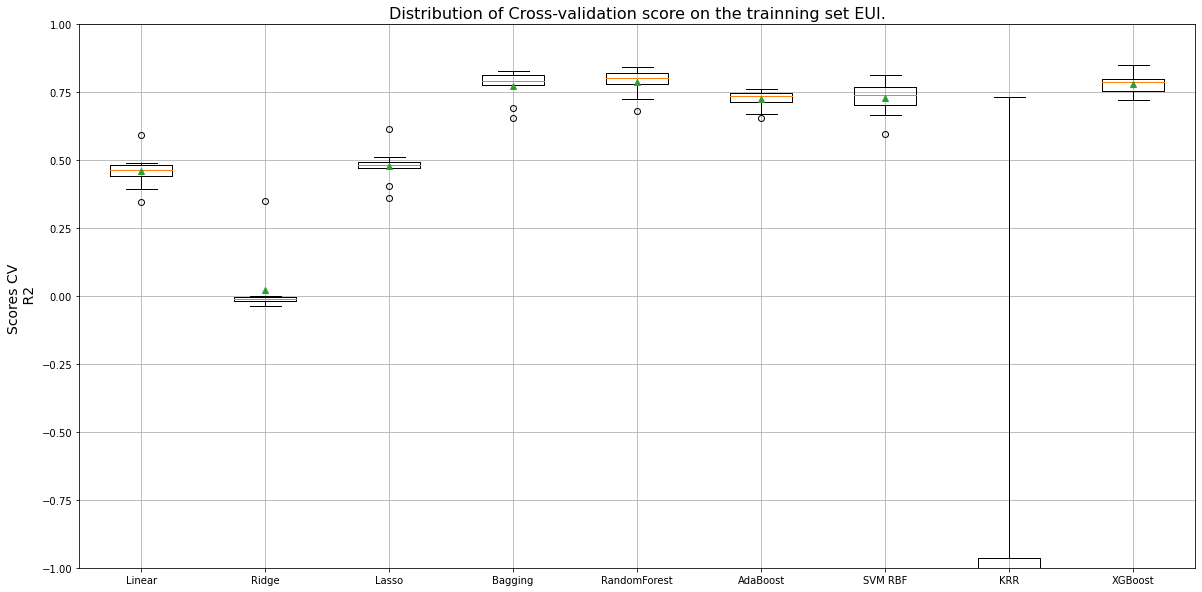

In [12]:
fig=plt.figure(figsize=[20,10])
plt.title("Distribution of Cross-validation score on the trainning set EUI.",size=16)
plt.boxplot(dico_results.values(),labels=dico_results.keys(),showmeans=True)
plt.ylabel("Scores CV \n R2",size=14)
plt.ylim(-1,1)
plt.grid()

# Applying models to GHG<a class="anchor" id="compare_mod_ghg"></a>

In [13]:
#dico_results=my_models(X_train_ghg, y_train_ghg,'r2')
dico_results=my_models(X_ghg, y_ghg,'r2', preprocessor)

Linear done
Ridge done
Lasso done
Bagging done
Random forest done
Adaboost done
SVM rbf done
KRR done
XGBoost done


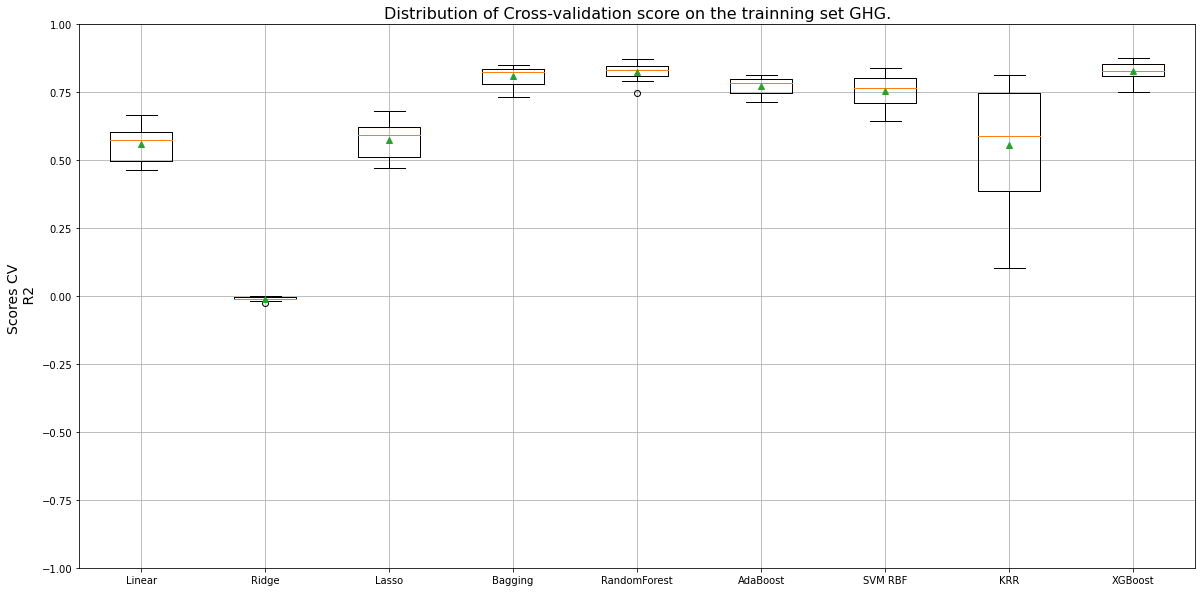

In [14]:
fig=plt.figure(figsize=[20,10])
plt.title("Distribution of Cross-validation score on the trainning set GHG.",size=16)
plt.boxplot(dico_results.values(),labels=dico_results.keys(),showmeans=True)
plt.ylabel("Scores CV \n R2",size=14)
plt.ylim(-1,1)
plt.grid()

# Trying models on RMSE metrics basis

> EUI

In [15]:
dico_results=my_models(X_eui,y_eui,'rmse', preprocessor)

Linear done
Ridge done
Lasso done
Bagging done
Random forest done
Adaboost done
SVM rbf done
KRR done
XGBoost done


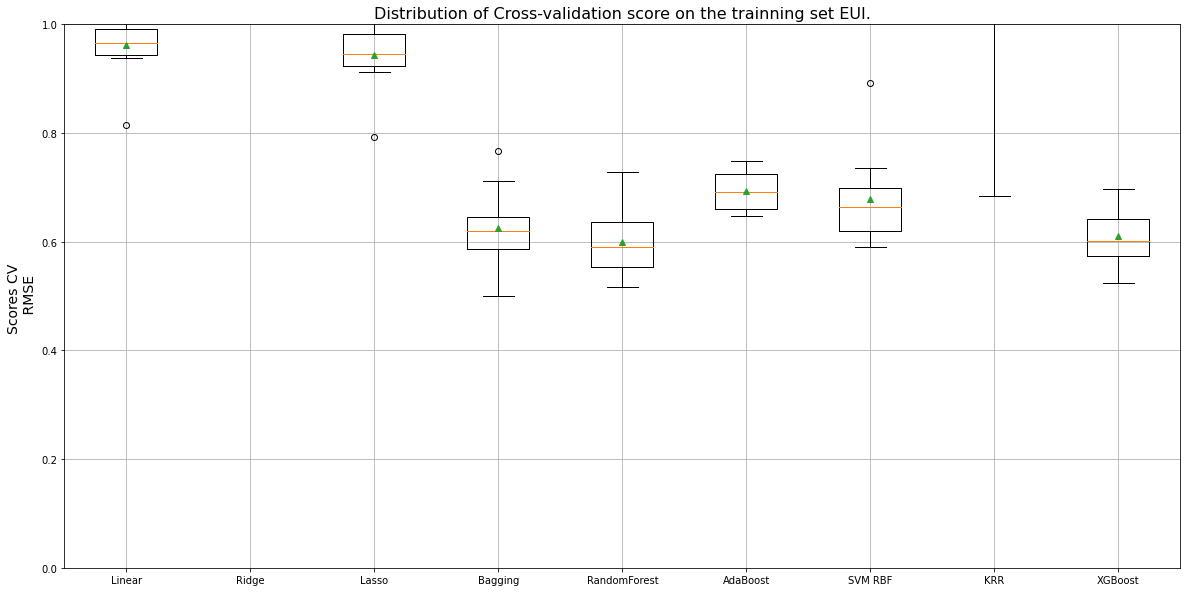

In [16]:
fig=plt.figure(figsize=[20,10])
plt.title("Distribution of Cross-validation score on the trainning set EUI.",size=16)
plt.boxplot(dico_results.values(),labels=dico_results.keys(),showmeans=True)
plt.ylabel("Scores CV \n RMSE",size=14)
plt.ylim(0,1)
plt.grid()

> GHG

In [17]:
dico_results=my_models(X_ghg,y_ghg,'rmse', preprocessor)

Linear done
Ridge done
Lasso done
Bagging done
Random forest done
Adaboost done
SVM rbf done
KRR done
XGBoost done


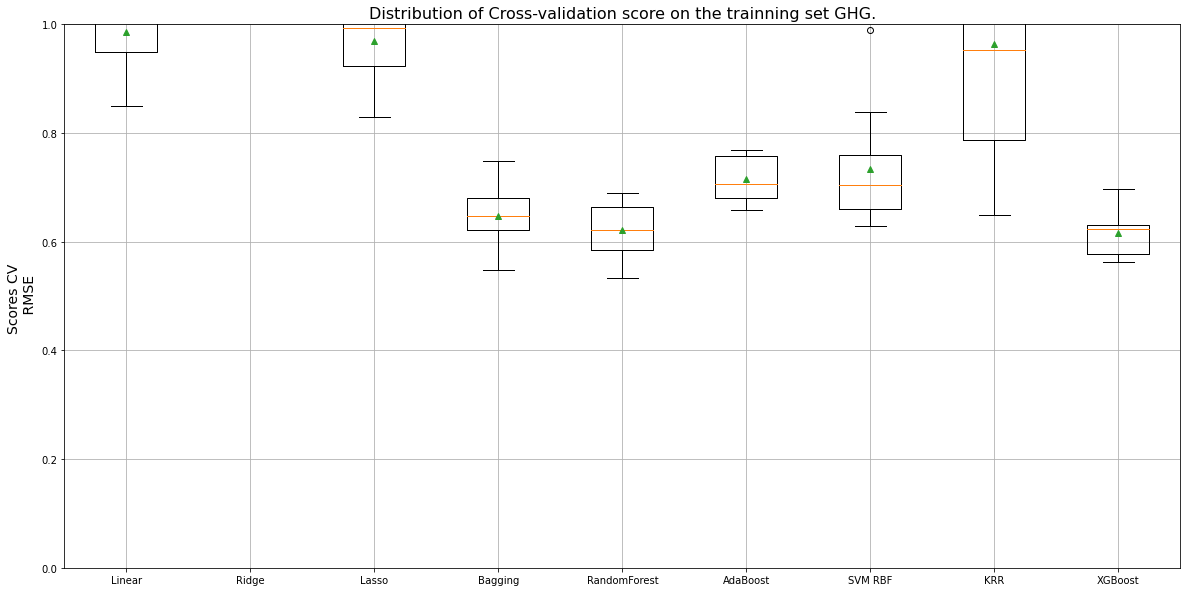

In [18]:
fig=plt.figure(figsize=[20,10])
plt.title("Distribution of Cross-validation score on the trainning set GHG.",size=16)
plt.boxplot(dico_results.values(),labels=dico_results.keys(),showmeans=True)
plt.ylabel("Scores CV \n RMSE",size=14)
plt.ylim(0,1)
plt.grid()

In [19]:
#STOP before handling long time running

According to the MAE random forest gives better result.

We see that the tree based model are giving way more better results than the others models.


# Calculating result of Random Forest on the test set for EUI and GHG target

In order to proceed we'll split the dataset into a training set and a testing set. The train test split will be done using shuffle.

Then we'll use a cross validation by grid search and we'll try to optimize some hyperparameters of our XGB model.We'll focus on:
*   min_child_weight
*   gamma
*   subsample, preventing overfitting if less than 1
*   colsample_bytree,
*   max_depth

#### Gridsearch, grid parameter

In [20]:
def RMSE(y_true,y_pred):
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    return rmse
def my_model_scorer():
    make_scorer(RMSE)#, greater_is_better=False)

The grid is voluntarly reduce to one parameter for time reason. The parameter values are choosen according to the best score that popped up on hours of grid search.

In [21]:
random_forest_grid = {
 'clf__max_depth': [40],
 'clf__max_features': ['auto'],
 'clf__min_samples_leaf': [1],
 'clf__min_samples_split': [5],
 'clf__n_estimators': [2000]}

#random_forest_grid = {#'clf__bootstrap': [True, False],
# 'clf__max_depth': [10, 40, 80, 60, 70, 80, 90, 100, None],
# 'clf__max_features': ['auto', 'sqrt'],
# 'clf__min_samples_leaf': [1, 2, 4],
# 'clf__min_samples_split': [2, 5, 10],
# 'clf__n_estimators': [1200, 1400, 1600, 1800, 2000]}

clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("clf", RandomForestRegressor(random_state=5))]
)

In [22]:
# xgb_param_grid = {
#         'clf__min_child_weight': [1, 5, 10], #default 1
#         'clf__gamma': [0, 0.5, 1, 1.5, 2, 5], #default 0, larger = more conservative
#         'clf__subsample': [0.6, 0.8, 1.0], #default 1, preventing overfitting if less than 1
#         'clf__colsample_bytree': [0.6, 0.8, 1.0], #default 1, 
#         'clf__max_depth': [6, 7], #default 6, depth of the tree the more the more overfit possible
# }

# clf = Pipeline(
#     steps=[("preprocessor", preprocessor), ("clf", xgb.XGBRegressor(random_state=5, objective ='reg:squarederror'))]
# )

In [23]:
def best_model_fit_and_plot(clf, random_forest_grid, X_train, y_train):
    grid = GridSearchCV(clf, random_forest_grid, scoring=my_model_scorer(), cv = 5)
    grid.fit(X_train, y_train)
    forest_model = grid.best_estimator_
    forest_best_params = grid.best_params_
    forest_best_score = grid.best_score_

    feature_importance = np.round(forest_model['clf'].feature_importances_,4)
    feature_names = forest_model.named_steps.preprocessor.get_feature_names_out()
    df_feature = pd.DataFrame(data = {'Feature names': feature_names, 'Feature importances': feature_importance}).sort_values(by='Feature importances', ascending=False)

    print(f"Best params :{forest_best_params}")
    print(f"Best score :{forest_best_score}")
    return forest_model, df_feature

> EUI

In [24]:
forest_model, df_feature = best_model_fit_and_plot(clf, random_forest_grid, X_train_eui, y_train_eui)

Best params :{'clf__max_depth': 40, 'clf__max_features': 'auto', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 5, 'clf__n_estimators': 2000}
Best score :0.7908770565861627


#### Features importance

In [25]:
fig = px.bar(df_feature[df_feature['Feature importances']>0.01], x='Feature importances', y='Feature names', text='Feature importances')
fig.update_layout(title='Feature importances of EUI dataset w-o energy starscore')
fig.show()

#### Predictions

In [26]:
y_pred_eui = forest_model.predict(X_test_eui)

In [27]:
def scoring_model(y_test, y_pred):
    metrics_list = {
        'r2_score' : r2_score, 
        'root_mean_squared_error' : mean_squared_error}
    result_list = []
    columns_list = []
    for e in metrics_list:
        if e == 'root_mean_squared_error':
            result_list.append(metrics_list[e](y_test, y_pred, squared='False'))
            columns_list.append(e)
        else :
            result_list.append(metrics_list[e](y_test, y_pred))
            columns_list.append(e)
    return pd.DataFrame(result_list, index=columns_list, columns = ['Score'])

In [28]:
df_score = scoring_model(y_test_eui, y_pred_eui)
df_score

,Score
r2_score,0.783256
root_mean_squared_error,0.360424


We see here that the RMSE is getting better on testing set with the improvement with gridsearch.

In [29]:
df_error = pd.DataFrame(np.exp(y_test_eui.values), columns=['Real values'])
df_error['Pred values'] = np.exp(y_pred_eui)
df_error['Error'] = df_error['Real values'] - df_error['Pred values']
df_error['Perc_error'] = np.abs(df_error['Error'] / df_error['Real values'])


df_error.describe()

,Real values,Pred values,Error,Perc_error
count,2.400000e+02,2.400000e+02,2.400000e+02,240.000000
mean,1.022832e+07,8.634019e+06,1.594300e+06,0.496607
std,1.544130e+07,1.192285e+07,9.154208e+06,0.717301
min,5.713320e+04,1.248538e+05,-2.854355e+07,0.007159
25%,1.633984e+06,1.936437e+06,-1.178217e+06,0.144292
50%,4.958423e+06,4.038845e+06,9.321402e+04,0.322532
75%,1.272756e+07,1.022808e+07,1.515126e+06,0.598525
max,1.146485e+08,9.619939e+07,6.518335e+07,7.770742


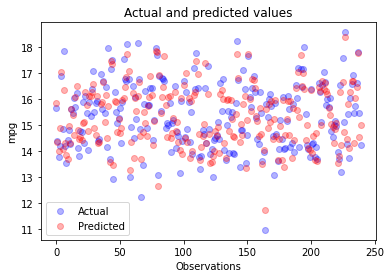

In [30]:
import matplotlib.pyplot as plt
_, ax = plt.subplots()

ax.scatter(x = range(0, y_test_eui.size), y=y_test_eui, c = 'blue', label = 'Actual', alpha = 0.3)
ax.scatter(x = range(0, y_pred_eui.size), y=y_pred_eui, c = 'red', label = 'Predicted', alpha = 0.3)

plt.title('Actual and predicted values')
plt.xlabel('Observations')
plt.ylabel('mpg')
plt.legend()
plt.show()

Text(0, 0.5, 'Frequency')

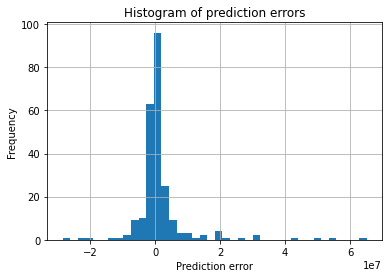

In [31]:
df_error['Error'].hist(bins = 40)
plt.title('Histogram of prediction errors')
plt.xlabel('Prediction error')
plt.ylabel('Frequency')

> GHG

In [32]:
forest_model, df_feature = best_model_fit_and_plot(clf, random_forest_grid, X_train_ghg, y_train_ghg)

Best params :{'clf__max_depth': 40, 'clf__max_features': 'auto', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 5, 'clf__n_estimators': 2000}
Best score :0.832508992624384


#### Features importance

In [33]:
forest_model, df_feature = best_model_fit_and_plot(clf, random_forest_grid, X_train_ghg, y_train_ghg)

Best params :{'clf__max_depth': 40, 'clf__max_features': 'auto', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 5, 'clf__n_estimators': 2000}
Best score :0.832508992624384


#### Predictions

In [34]:
y_pred_ghg = forest_model.predict(X_test_ghg)

In [35]:
df_score = scoring_model(y_test_ghg, y_pred_ghg)
df_score

,Score
r2_score,0.783413
root_mean_squared_error,0.403690


In [36]:
df_error = pd.DataFrame(np.exp(y_test_ghg.values), columns=['Real values'])
df_error['Pred values'] = np.exp(y_pred_ghg)
df_error['Error'] = np.abs(df_error['Real values'] - df_error['Pred values'])
df_error['Perc_error'] = df_error['Error'] / df_error['Real values'] 


df_error.describe()

,Real values,Pred values,Error,Perc_error
count,240.000000,240.000000,240.000000,240.000000
mean,186.525167,148.586536,84.934099,0.523305
std,358.318389,254.063918,184.147086,0.586711
min,0.400000,0.702100,0.091910,0.004282
25%,34.742500,32.724350,9.170877,0.171745
50%,75.555000,73.277162,26.468852,0.386764
75%,186.337500,176.569539,68.612751,0.672519
max,3243.480000,2389.761204,1314.446671,3.927091


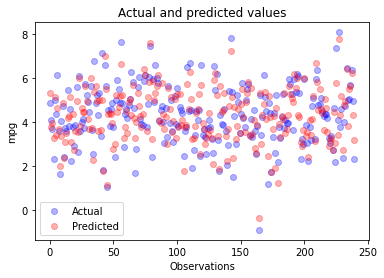

In [37]:
import matplotlib.pyplot as plt
_, ax = plt.subplots()

ax.scatter(x = range(0, y_test_ghg.size), y=y_test_ghg, c = 'blue', label = 'Actual', alpha = 0.3)
ax.scatter(x = range(0, y_pred_ghg.size), y=y_pred_ghg, c = 'red', label = 'Predicted', alpha = 0.3)

plt.title('Actual and predicted values')
plt.xlabel('Observations')
plt.ylabel('mpg')
plt.legend()
plt.show()

Text(0, 0.5, 'Frequency')

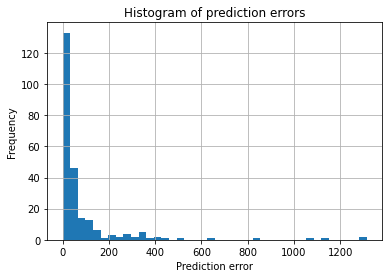

In [38]:
df_error['Error'].hist(bins = 40)
plt.title('Histogram of prediction errors')
plt.xlabel('Prediction error')
plt.ylabel('Frequency')

# Energy star score analysis <a class="anchor" id="energy_star"></a>

Let's check the capacity of the energy star score to predict EUI and GHG consumptions and emissions.

We will analyse on a simple regression the capabailities of the energy star score to predict the EUI and GHG.

In [39]:
df_prepared_temp = df_prepared[~df_prepared['ENERGYSTARScore'].isna()]
df_prepared_temp.shape

(665, 14)

In [40]:
df_starScore_eui = df_prepared_temp[['ENERGYSTARScore', 'SiteEnergyUse(kBtu)']]
df_starScore_ghg = df_prepared_temp[['ENERGYSTARScore', 'TotalGHGEmissions']]

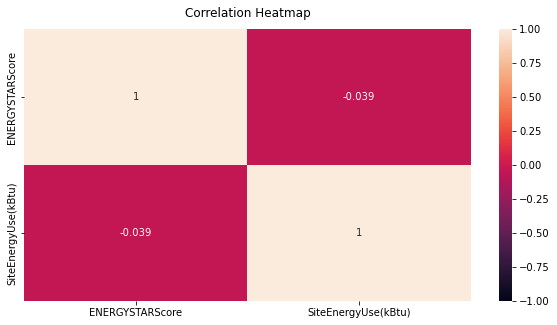

In [41]:
plt.figure(figsize=(10, 5))
heatmap = sns.heatmap(df_starScore_eui.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

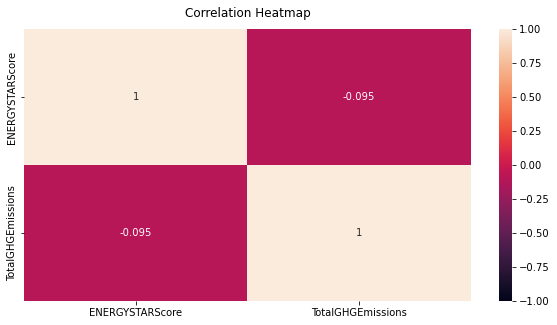

In [42]:
plt.figure(figsize=(10, 5))
heatmap = sns.heatmap(df_starScore_ghg.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

We see that the GHG are slitghtly more correlated to the enrgy star score but not enough to perform any linear regression.

Both target are not 'linearly' correlated to the Energystarscore.

To test the capability of energystarscore to predict any of the two target.

Let's check the distribution of this variable:

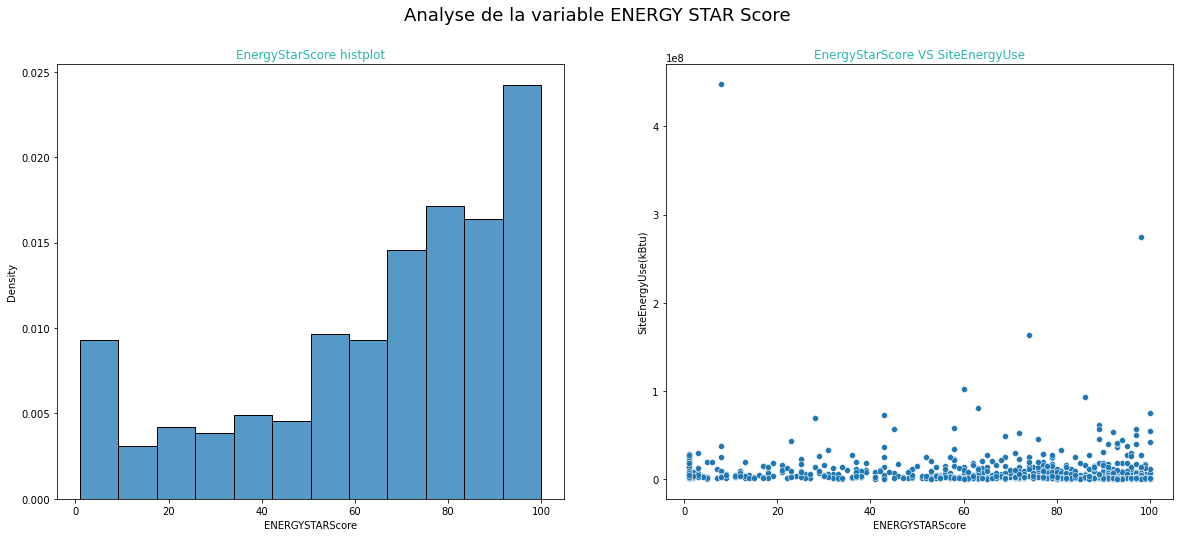

In [43]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20,8))
sns.histplot(data=df_starScore_eui, x='ENERGYSTARScore', stat="density", ax=axes[0])
axes[0].set_title("EnergyStarScore histplot", color='#2cb7b0')
sns.scatterplot(data=df_starScore_eui, y='SiteEnergyUse(kBtu)', x='ENERGYSTARScore', ax=axes[1])
axes[1].set_title("EnergyStarScore VS SiteEnergyUse", color='#2cb7b0')
plt.suptitle("Analyse de la variable ENERGY STAR Score", fontsize=18)
plt.show()

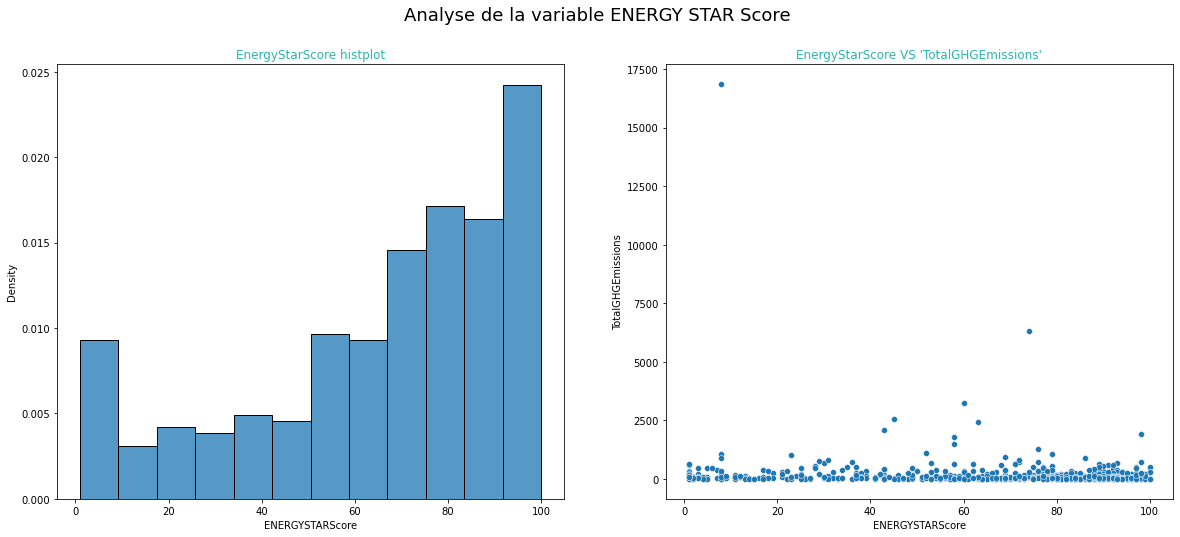

In [44]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20,8))
sns.histplot(data=df_starScore_ghg, x='ENERGYSTARScore', stat="density", ax=axes[0])
axes[0].set_title("EnergyStarScore histplot", color='#2cb7b0')
sns.scatterplot(data=df_starScore_ghg, y='TotalGHGEmissions', x='ENERGYSTARScore', ax=axes[1])
axes[1].set_title("EnergyStarScore VS 'TotalGHGEmissions'", color='#2cb7b0')
plt.suptitle("Analyse de la variable ENERGY STAR Score", fontsize=18)
plt.show()

We will do a correlation check between the Energy Star Score and our two targert.

As the three variables are quantitative and as we see that the scatter plot shows that the distributions are not following a normal trend, we will use the Kendall test to test the correlation.

The Kendall Tau is a mesure of correspondance between two rankings. If the value is close to 1 then the agreement between the two variables is strong otherwize, if it's close to -1 then the desagreement is interpreted.


In [45]:
pd.DataFrame(kendalltau(df_starScore_eui['ENERGYSTARScore'], df_starScore_eui['SiteEnergyUse(kBtu)']), index=['Kendall Tau', 'p-value'], columns=['resultat_test'])

,resultat_test
Kendall Tau,-0.079223
p-value,0.002401


In [46]:
pd.DataFrame(kendalltau(df_starScore_ghg['ENERGYSTARScore'], df_starScore_ghg['TotalGHGEmissions']), index=['Kendall Tau', 'p-value'], columns=['resultat_test'])

,resultat_test
Kendall Tau,-0.055169
p-value,0.034527


According to the test, and for both targerts, there is a statistical significance (pvalue < 0,05) in saying that the two variables are not correlated ( Tau near 0).

Accordingly, we cannot say that the variable energy star score is possibly used to perform itself predictions on the consumptions or emissions of GhG.

To test the interest in using the EnergyStarScore we will simply add the variable to our dataset and check if there is a significant change in our predictions score.

#### Adding the variable Energystarscore to our XGBoost model to check if there is any increase in performance

In [47]:
df_prepared_temp = df_prepared[~df_prepared['ENERGYSTARScore'].isna()]
df_prepared_temp.shape

(665, 14)

In [48]:
df_starScore_eui = df_prepared_temp.drop(columns='TotalGHGEmissions')
df_starScore_ghg = df_prepared_temp.drop(columns='SiteEnergyUse(kBtu)')

In [49]:
#log targets
logtransformer = FunctionTransformer(np.log, inverse_func = np.exp, check_inverse = True)
df_starScore_eui['SiteEnergyUse(kBtu)'] = logtransformer.transform(df_starScore_eui['SiteEnergyUse(kBtu)'])
df_starScore_ghg['TotalGHGEmissions'] = logtransformer.transform(df_starScore_ghg['TotalGHGEmissions'])

In [50]:
#creating X and y variables
X_ghg = df_starScore_ghg.drop(columns= ['TotalGHGEmissions'])
y_ghg = df_starScore_ghg['TotalGHGEmissions']

X_eui = df_starScore_eui.drop(columns=['SiteEnergyUse(kBtu)'])
y_eui = df_starScore_eui['SiteEnergyUse(kBtu)']

In [51]:
X_train_ghg, X_test_ghg, y_train_ghg, y_test_ghg = train_test_split(X_ghg, y_ghg, test_size=0.25, random_state=5)
X_train_eui, X_test_eui, y_train_eui, y_test_eui = train_test_split(X_eui, y_eui, test_size=0.25, random_state=5)

In [52]:
forest_model, df_feature = best_model_fit_and_plot(clf, random_forest_grid, X_train_ghg, y_train_ghg)

Best params :{'clf__max_depth': 40, 'clf__max_features': 'auto', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 5, 'clf__n_estimators': 2000}
Best score :0.8159866433943448


### Feature importances

In [53]:
fig = px.bar(df_feature[df_feature['Feature importances']>0.01], x='Feature importances', y='Feature names', text='Feature importances')
fig.update_layout(title='Feature importances of EUI dataset w-o energy starscore')
fig.show()

In [54]:
y_pred_eui_StarS = forest_model.predict(X_test_eui)

In [55]:
df_score = scoring_model(y_test_eui, y_pred_eui_StarS)
df_score

,Score
r2_score,-65.474398
root_mean_squared_error,125.031183


#### GHG

In [56]:
forest_model, df_feature = best_model_fit_and_plot(clf, random_forest_grid, X_train_ghg, y_train_ghg)

Best params :{'clf__max_depth': 40, 'clf__max_features': 'auto', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 5, 'clf__n_estimators': 2000}
Best score :0.8159866433943448


### Feature importances

In [57]:
fig = px.bar(df_feature[df_feature['Feature importances']>0.01], x='Feature importances', y='Feature names', text='Feature importances')
fig.update_layout(title='Feature importances of EUI dataset w-o energy starscore')
fig.show()

> Prediction

In [58]:
y_pred_ghg_StarS = forest_model.predict(X_test_ghg)

In [59]:
df_score = scoring_model(y_test_ghg, y_pred_ghg_StarS)
df_score

,Score
r2_score,0.840918
root_mean_squared_error,0.391895


We see that adding energystarscore to the model is not bringing enough improvement to use it considering the price to get the information as per the project highlines.